In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from matplotlib import animation
import pandas as pd
import networkx as nx
import seaborn as sns

# rumour spreading 

- X: spreader (infected) -- 1
- Y: ignorant (susceptible) -- 0
- Z: stifler (recovered) -- 2


Maki-Thompson dynamics:

$X + Y \xrightarrow{\beta} 2X $ 

$X + X \xrightarrow{\mu} Z + X $

$X + Z \xrightarrow{\mu} 2Z$


At each timestep, the status of every node in the model is updated. For each node it is decided if the event (which could be no event) occurs on the ABM or static network (given by probability $\alpha$):
 - on the ABM, probabilities are given by:
     - $ p1 = 1 - (1- \beta)^{N_x} $ -- probability a susceptible node becomes infected, depends on the number of infected nodes ($N_x$) within each nodes interacting radius
     - $ p2 =1 - (1- \mu)^{N_x} $ -- probability an infected node recovers, depending on the number of infected nodes within its interacting radius
     - $p3 = 1 - (1- \mu)^{N_z}$ -- probability an infected node recovers, depedning on the number of recovered nodes within its interacting radius
 - on the static network, the probabilities are given by:
     - $\beta$ -- for each infected node a reactive process is carried out. Each of its susceptible neighbours is infected with probability $\beta$
     - $\mu$ -- infected nodes recover with probability $\mu$, if they are connected to another infected node or a recovered node

# Parameters

- $\beta$ - probability of infection
- $\mu$ - probability of recovery
- $r$ - radius of interaction
- $v$ - velocity of the particles 
- $\alpha$ - which dynamics infection is spread


#### Question 1: I'm confused why the probability of infection on the ABM and the static network (given by $\beta$) should be the same? Due to the magnitude of $p1$, all of the dynamics are dominated by the ABM, even when $\alpha$ is small. 

#### Question 2: why is the probability of recovery (given by $\mu$) the same for both scenarios. Should $\mu$ not be smaller for "$X + Z \xrightarrow{\mu} 2Z$" and larger for "$X + X \xrightarrow{\mu} Z + X$"?


In [4]:
α = 0.1
μ = 0.01
β = 0.1
vel = 0.1

N = 100
av_degree = 8
m = int(av_degree/2)
D = np.sqrt(100)
G_ba = nx.barabasi_albert_graph(N,m)


<IPython.core.display.Javascript object>


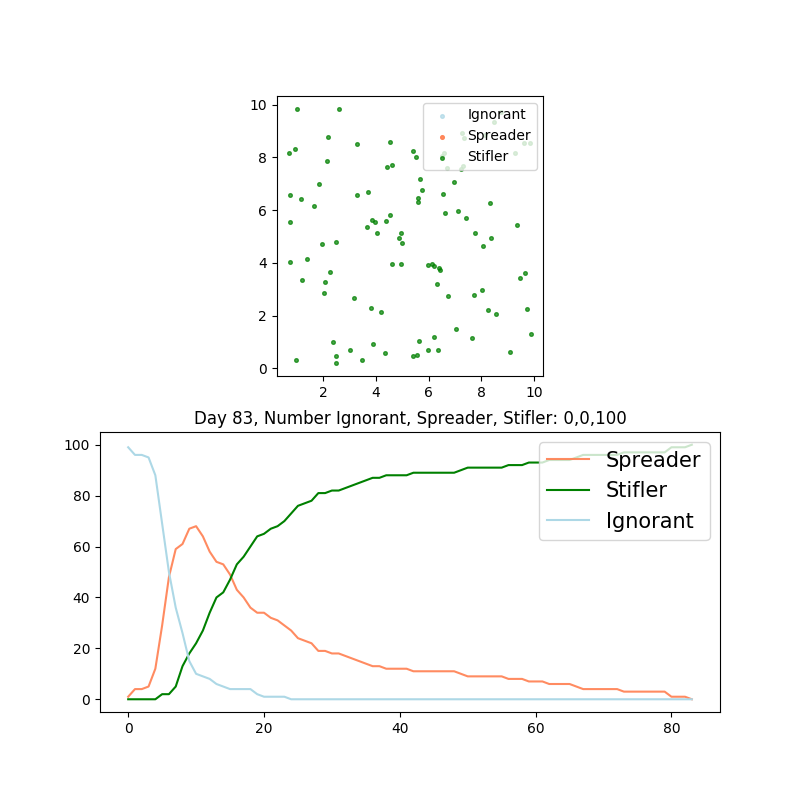

--- 13.572914600372314 seconds ---


In [5]:
average_inf1 = []
for l in range(1):
    t=0
    A = np.zeros(shape=(N,4)) #col1 - index, col2 - x position on grid, col3 - y position on grid, col4 - radius 
    initial = random.randint(0,N-1) #initial case
    
    S = np.zeros(N, dtype=np.int64) #status -- 0,1,2 -- ignorant,spreader, stifler

    S[initial] = 1
    A[:,0] = np.arange(0,N, dtype = int)
    A[:,1]= np.random.uniform(0,D, size = N)
    A[:,2] = np.random.uniform(0,D, size =N)
    A[:,3] = 2 #dirac delta radii of interaction
    
    stifler = [i for i in range(np.size(S)) if S[i]==2]
    spreader = [i for i in range(np.size(S)) if S[i]==1]
    ignorant = [i for i in range(np.size(S)) if S[i]==0]

    Igno = [len(ignorant)]
    Stif = [len(stifler)]
    Spre =[len(spreader)]
    
    time_plot=[0]
    %matplotlib notebook

    start_time = time.time()

    fig = plt.figure(figsize = (8,8))

    ax = fig.add_subplot(211)

    plt.xticks([0, D], ['0','L'], fontsize = 20)
    plt.yticks([D], ['L'], fontsize = 20)
    ax1 = fig.add_subplot(212)

    plt.ion

    fig.show()
    fig.canvas.draw()

    while t<1000 and sum(S ==1)>0:
        ξ = np.random.uniform(-np.pi, np.pi, size = N)
        V = (vel*np.cos(ξ), vel*np.sin(ξ))
        p = np.random.uniform(0,1, size = N)


        A[:, 1] = (A[:, 1]+V[0])%D
        A[:, 2] = (A[:, 2]+V[1])%D

        

        N_x = np.zeros(len(A[:,0])) #number of agents in nbhd updates for each time step
        N_z = np.zeros(len(A[:,0]))
        Num_x = [A[a,0] for a in np.where(S==1)[0]]
        Num_z = [A[b, 0] for b in np.where(S==2)[0]]
        for ind1 in A[:,0]:
            ind1 = int(ind1)
            ################### Number of spreaders within each nbhd #################
            for ind2 in Num_x:
                ind2 = int(ind2)
                if (A[ind1, 1] - A[ind2, 1])**2+ (A[ind1, 2]-A[ind2, 2])**2 < A[ind1,3]**2:
                    N_x[ind1] +=1
            
            ################## Number of stiflers within each nbhd #######################################
            for ind3 in Num_z:
                ind3 = int(ind3)
                if (A[ind1, 1] - A[ind3, 1])**2+ (A[ind1, 2]-A[ind3, 2])**2 < A[ind1,3]**2:
                    N_z[ind1] +=1
                
        
        
        for node in A[:,0]: #Each node is updated at every timestep
            node = int(node)
            if np.random.uniform(0,1)<α: #Event on ABM
                if S[node]==0:
                    prob_inform = 1-((1-β)**N_x[node]) #'X+Y to 2X'
                    if np.random.uniform(0,1)<prob_inform:
                        S[node]= 1
                elif S[node] ==1: #'X to Z'
                    prob_XZtoZZ = 1-((1-μ)**N_z[node])
                    prob_XXtoXZ = 1-((1-μ)**N_x[node])
                    if np.random.uniform(0,1) < prob_XZtoZZ:
                        S[node] = 2
                    elif np.random.uniform(0,1) < prob_XXtoXZ:
                        S[node] = 2
            else: #Event on static network
                if S[node]==1:
                    for neighbours in G_ba.edges(node): # for all node connected to the spreader
                        if (np.random.uniform(0,1) < β) and (S[neighbours[1]]==0): #spread
                            S[neighbours[1]]=1
                        elif (np.random.uniform(0,1)<μ) and (S[neighbours[1]]==1): #spread node recovers 
                            S[node] =2
                            break
                        elif (np.random.uniform(0,1)<μ) and (S[neighbours[1]]==2): 
                            S[node] = 2
                            break


        t = t + 1

        spreadind = [i for i in range(np.size(S)) if S[i]==1]
        stiflerind = [i for i in range(np.size(S)) if S[i]==2]
        ignorantind = [i for i in range(np.size(S)) if S[i]==0]


        Igno.append(len(ignorantind))
        Stif.append(len(stiflerind))
        Spre.append(len(spreadind))
        time_plot.append(t)

        xspreadplot = A[:,1][spreadind]
        yspreadplot = A[:,2][spreadind]
        xstiflerplot = A[:,1][stiflerind]
        ystiflerplot = A[:,2][stiflerind]
        xignorplot = A[:,1][ignorantind]
        yignorplot = A[:,2][ignorantind]


        ###################### PLOTS #####################
        ax.clear()
        ax1.clear()
        plt.title('Day {}, Number Ignorant, Spreader, Stifler: {},{},{}'.format(t, np.size(xignorplot), np.size(xspreadplot), np.size(xstiflerplot)))
        ax.scatter(xignorplot, yignorplot, c='lightblue', marker='o', s=7, alpha = 0.7, label='Ignorant')
        ax.scatter(xspreadplot, yspreadplot, c='coral', marker='o', s = 7, alpha =0.9, label='Spreader')
        ax.scatter(xstiflerplot, ystiflerplot, c='green', marker='o',s = 7, alpha = 0.7, label='Stifler')
        ax.axis([0, D, 0, D])
        ax.axis('scaled')
        ax.legend(loc = 'upper right', fontsize = 10)

        ax1.plot(time_plot,Spre,c='coral', alpha = 0.9, label='Spreader')
        ax1.plot(time_plot,Stif,c = 'green', label='Stifler')
        ax1.plot(time_plot,Igno, c='lightblue', label = 'Ignorant')
        ax1.legend(loc = 'upper right', fontsize = 15)


        fig.canvas.draw()
#         average_inf1.append(Inf)
    print("--- %s seconds ---" % (time.time() - start_time))